# SoapySDR.jl
### MIT 18.337/6.338 Fall 2018 Final Project
Sarah Greer (1st year CSE-Math PhD student, sygreer@mit.edu)

A Julia wrapper for [SoapySDR](https://github.com/pothosware/SoapySDR/wiki) to allow for software-defined radio processing to be done in Julia

### Software-defined radio receiver diagram
<img src="SDR_Julia.png">
$\Omega_0 = $center frequency

$\Omega_s = $sampling frequency

$\Omega_c = $cutoff frequency

### Goal of package: Process [IQ](http://whiteboard.ping.se/SDR/IQ) data in Julia
IQ data: takes the orthogonal components of the real CT received signal and converts it to a complex DT time series
- I: "in-phase". Real component of complex IQ signal. Cosine
- Q: "quadrature". Imaginary component of complex IQ signal. Sine

The IQ data is modulated to baseband from the real signal received in the RTL-SDR, $x(t)$,

$$ x(t) = I(t) \cos(\Omega_0 t) - Q(t) \sin(\Omega_0t) $$

where $I(t)$ is the in-phase component, $Q(t)$ is the quadrature component, and $f_h$ is the hardware center frequency. This turns into a complex signal which can be discretized with sampling frequency $\Omega_s$ as

$$y[t] = I[t] + iQ[t]$$

Allows data to be transmitted in three parameters: amplitude, phase, and frequency.

### Some software defined radio packages
1. [GNURadio](https://www.gnuradio.org/)
2. [GQRX](http://gqrx.dk/)
3. [CubicSDR](https://cubicsdr.com/)
5. [rtl-sdr](https://github.com/osmocom/rtl-sdr) (for the Realtek RTL2832)
4. [SoapySDR](https://github.com/pothosware/SoapySDR/wiki) (for many SDR receivers)

### Some cool SDR applications
1. ADS-B receivers (like [FlightAware](https://flightaware.com/live/))
2. NOAA satellite APT [image](https://twitter.com/sygreer/status/949809178155143169) [receiving](http://www.stargazing.net/david/NOAA/)
3. [Receive SSTV images from the ISS](https://amsat-uk.org/beginners/iss-sstv/)
4. Listen to FM radio (what this notebook does)

### Julia packages used
1. [FFTW.jl](https://github.com/JuliaMath/FFTW.jl)
2. [DSP.jl](https://github.com/JuliaDSP/DSP.jl)
3. [PyPlot.jl](https://github.com/JuliaPy/PyPlot.jl)
4. [SampledSignals.jl](https://github.com/JuliaAudio/SampledSignals.jl)
5. [WAV.jl](https://github.com/dancasimiro/WAV.jl)

#### 1) Load packages

In [1]:
include("../src/SoapySDR.jl")
using FFTW, DSP, PyPlot, Printf
include("fmDemod.jl");

#### 2) Check SDR devices and properties

In [2]:
# enumerate devices
(kwargs, sz) = SoapySDR.SoapySDRDevice_enumerate()

t = unsafe_load(kwargs)
for i = 1:Int(sz[])
    @printf "\nNumber of results in device = %i\n" t.size
    @printf "Found device #%d: \n" i
    keys = unsafe_string.(unsafe_wrap(Array, t.keys, t.size))
    vals = unsafe_string.(unsafe_wrap(Array, t.vals, t.size))
    for j = 1:t.size
        @printf "    %s = %s\n" keys[j] vals[j]
    end
    @printf "\n"
end

SoapySDR.SoapySDRKwargs_clear(kwargs)


Number of results in device = 8

Found Rafael Micro R820T tuner



Found device #1: 
    available = Yes
    driver = rtlsdr
    label = Generic RTL2832U OEM :: 00000001
    manufacturer = Realtek
    product = RTL2838UHIDIR
    rtl = 0
    serial = 00000001
    tuner = Rafael Micro R820T



#### 3) Initialize the SDR device and view parameters

In [3]:
# create device instance
# args can be user defined or from the enumeration result
sdr = SoapySDR.SoapySDRDevice_make(kwargs)

# check device is initialized correctly
if (unsafe_load(sdr) == C_NULL)
    @printf "SoapySDRDevice_make fail: %s\n" unsafe_string(SoapySDR.SoapySDRDevice_lastError())
end

# query device info
# List antennas
(name, sz) = SoapySDR.SoapySDRDevice_listAntennas(sdr, SoapySDR.SOAPY_SDR_RX, 0)
@printf "Rx antennas: "
for i=1:Int(sz[])
    @printf "%s, " unsafe_string.(unsafe_wrap(Array, name, Int(sz[])))[i]
end
@printf "\n"

# List gains
(name2, sz2) = SoapySDR.SoapySDRDevice_listGains(sdr, SoapySDR.SOAPY_SDR_RX, 0)
@printf "Rx gains: "
for i=1:Int(sz[])
    @printf "%s, " unsafe_string.(unsafe_wrap(Array, name2, Int(sz2[])))[i]
end
@printf "\n"

(ranges, sz) = SoapySDR.SoapySDRDevice_getFrequencyRange(sdr, SoapySDR.SOAPY_SDR_RX, 0)

@printf "Rx freq ranges: "
for i = 1:Int(sz[])
    range =  unsafe_wrap(Array, ranges, Int(sz[]))[i]
    @printf "[%g Hz -> %g Hz], " range.minimum range.maximum
end
@printf "\n"

Rx antennas: RX, 
Rx gains: TUNER, 
Rx freq ranges: [

Found Rafael Micro R820T tuner


2.3999e+07 Hz -> 1.764e+09 Hz], 


#### 4) Set sample rate and center frequency

In [4]:
# apply settings
sampRate = 2048e3
if (SoapySDR.SoapySDRDevice_setSampleRate(sdr, SoapySDR.SOAPY_SDR_RX, 0, sampRate) != 0)
    @printf "setSampleRate fail: %s\n" unsafe_string(SoapySDR.SoapySDRDevice_lastError())
end
@printf "Sample rate: %.3f MHz\n" (sampRate/ 1e6)

f0 = 104.1e6
if (SoapySDR.SoapySDRDevice_setFrequency(sdr, SoapySDR.SOAPY_SDR_RX, 0, f0) != 0)
    @printf "setFrequency fail: %s\n" unsafe_string(SoapySDR.SoapySDRDevice_lastError())
end
@printf "Center frequency: %.3f MHz\n" (f0/1e6)

Sample rate: 2.048 MHz
Center frequency: 

[R82XX] PLL not locked!


104.100 MHz


#### 5) Prepare for receiving data

In [5]:
# create a re-usable buffer for rx samples
buffsz = 1024
buff = Array{ComplexF32}(undef, buffsz)

# receive some samples
timeS = 15 
timeSamp = Int(floor(timeS * sampRate / buffsz))
storeIq = zeros(ComplexF32, buffsz*timeSamp)

# Parameters for streaming
flags = Ref{Cint}()
timeNs = Ref{Clonglong}()
buffs = [buff] 

# Array to store IQ data
storeBuff = zeros(ComplexF32,timeSamp, buffsz);

@printf "Receiving %i seconds of data at %.3f MHz = %i samples\n" timeS (sampRate/1e6) (timeSamp*buffsz)
@printf "%i buffers each of size %i" timeSamp buffsz

Receiving 15 seconds of data at 2.048 MHz = 30720000 samples
30000 buffers each of size 1024

#### 6) Receive data...

In [6]:
# set up a stream (complex floats)
rxStream = SoapySDR.SoapySDRStream()
if (SoapySDR.SoapySDRDevice_setupStream(sdr, rxStream, SoapySDR.SOAPY_SDR_RX, SoapySDR.SOAPY_SDR_CF32, C_NULL, 0) != 0)
    @printf "setupStream fail: %s\n" unsafe_string(SoapySDR.SoapySDRDevice_lastError())
end

# start streaming
SoapySDR.SoapySDRDevice_activateStream(sdr, rxStream, 0, 0, 0)

storeBuff = zeros(ComplexF32,timeSamp, buffsz)
for i=1:timeSamp
    SoapySDR.SoapySDRDevice_readStream(sdr, rxStream, buffs, buffsz, flags, timeNs, 100000)
    local storeBuff[i,:] = buff
end

# shutdown the stream
SoapySDR.SoapySDRDevice_deactivateStream(sdr, rxStream, 0, 0)  # stop streaming
SoapySDR.SoapySDRDevice_closeStream(sdr, rxStream);

[INFO] Using format CF32.


#### 7) Reformat data

In [7]:
storeFft = zeros(timeSamp, buffsz)
for i = 1:size(storeBuff)[1]
    local storeFft[i,:] = 20 .*log10.(abs.(fftshift(fft(storeBuff[i,:]))))
end

# get IQ array
storeIq = Array(reshape(storeBuff', :, size(storeBuff)[1]*size(storeBuff)[2])')[:];

#### 8) Waterfall plot

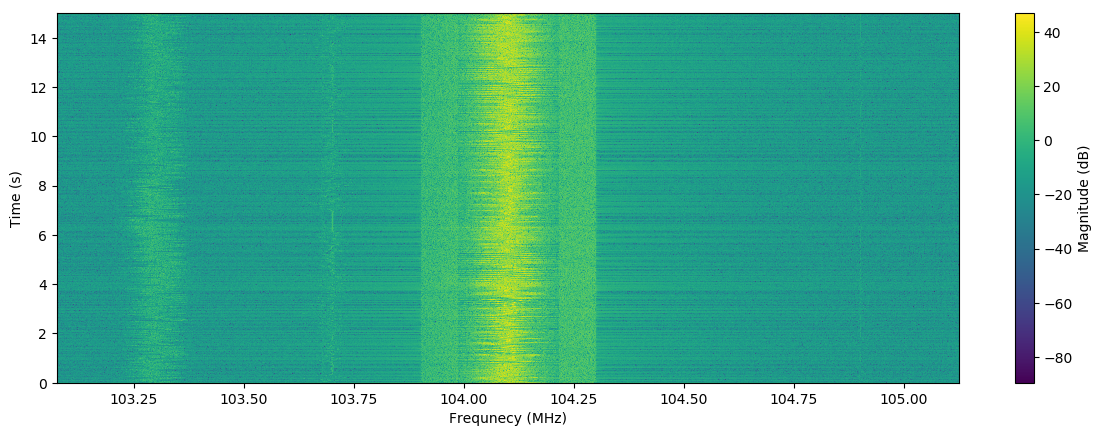

In [8]:
plotTimeFreq(storeFft, sampRate, f0);

#### 9) FM demodulation and plot

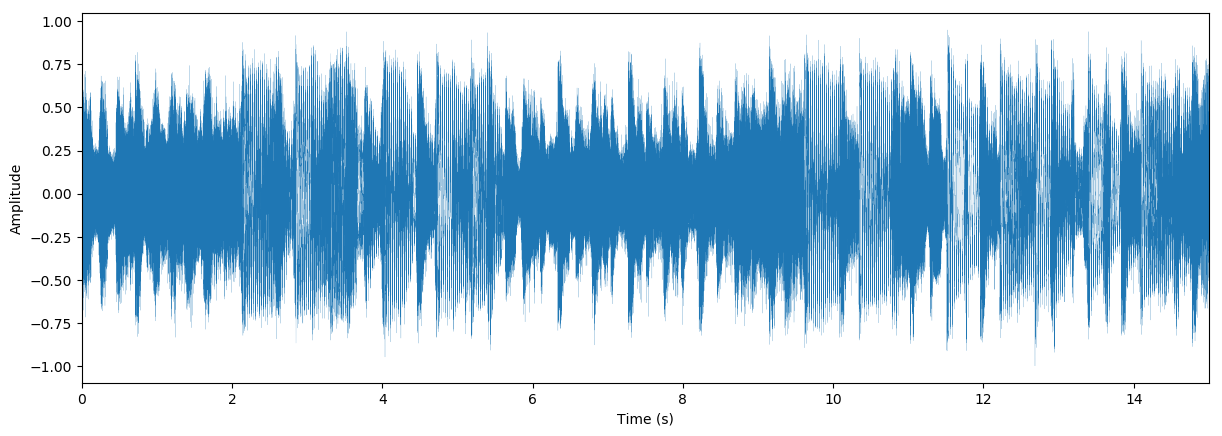

In [9]:
(data, fs) =  fmDemod(storeIq, sampRate)
plotTime(data, fs);

#### 10) Play FM demodulation

In [10]:
wavwrite(data, "demod.wav", Fs=fs)

In [11]:
wavplay(data, fs)

#### 11) Unmake SDR device

In [12]:
SoapySDR.SoapySDRDevice_unmake(sdr);